# Aprendizaje No Supervisado: Autoencoders

**Author:** Jhosimar George Arias Figueroa

En este notebook, veremos cómo aplicar técnicas de deep learning a la tarea de aprendizaje no supervisado mediante el uso de Autoencoders.

Este notebook analizará temas como redes neuronales fully connected (FC), Vanilla Autoencoders, Denoising Autoencoders y clustering.

### Aplicaciones


- Dimensionality reduction
- Feature learning
- Denoising or filling holes

## Setup

Comencemos importando las bibliotecas y funciones que necesitaremos.

In [1]:
import tensorflow as tf
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


##MNIST Dataset

El conjunto de datos MNIST consta de 70000 dígitos escritos a mano con un tamaño de 28 × 28 píxeles y 10 clases, de los cuales 60000 imágenes se consideran para entrenamiento y 10000 imágenes para pruebas. Este conjunto de datos se puede obtener directamente desde el [framework de Keras](https://keras.io/datasets/).

In [2]:
print("Loading mnist dataset...")

# cargar datos mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# imprimir dimension de cada dataset
print('Train size: ', X_train.shape, ' Test size: ', X_test.shape)

Loading mnist dataset...
11501568/11490434 [==============================] - 1s 0us/step
('Train size: ', (60000, 28, 28), ' Test size: ', (10000, 28, 28))


##Visualización de la data

Revisemos que tipo de imágenes contiene el dataset.

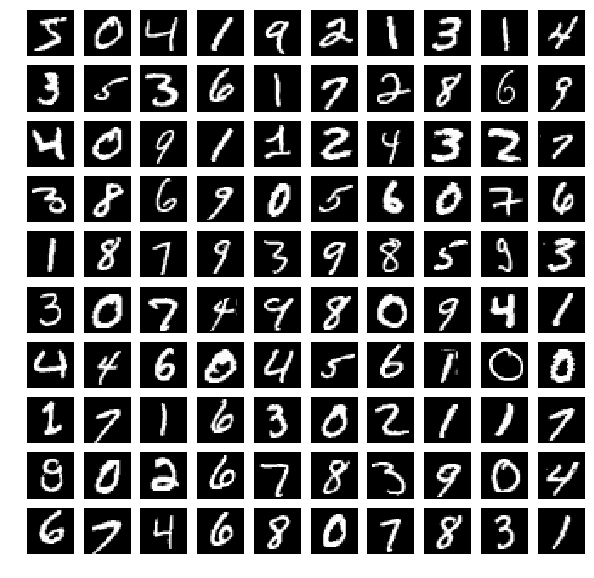

In [3]:
plt.figure(figsize=[10,10])
for i in range(0,100):
  plt.subplot(10,10,i+1)
  plt.imshow(X_train[i], interpolation='none',cmap=plt.get_cmap('gray'))
  plt.axis('off')

## Preprocesamiento los datos


Nuestro modelo recibirá data basada en tipos de datos y tamaños específicos. Por lo tanto es necesario modificarlos:

- Tipos de datos: los datos de entrada son de tipo float32 mientras que las etiquetas son de tipo int32.
- Tamaños: los datos de entrada son de tamaño (num_elementos, num_features).

Adicionalmente, un paso muy importante es normalizar los datos para que esten en el rango [0,1].

In [4]:
def flatten_array(x):
  shape = np.prod(x.shape[1:])
  return x.reshape(-1,shape)

def data_preprocessing(X_train, Y_train, X_test, Y_test, flatten=False):
  ## Cambiar tipos de datos
  x_train = X_train.astype(np.float32)
  x_test = X_test.astype(np.float32)
  y_train = Y_train.astype(np.int32)
  y_test = Y_test.astype(np.int32)

  if flatten:
    ## Flatten data
    x_train = flatten_array(x_train)
    x_test = flatten_array(x_test)

  # normalizar data para estar en el rango [0,1]
  x_train = x_train / 255.0
  x_test = x_test / 255.0
  
  return x_train, y_train, x_test, y_test

x_train_prep, y_train_prep, x_test, y_test = data_preprocessing(X_train, Y_train, X_test, Y_test, True)
print('New train size: ', x_train_prep.shape, ' New test size: ', x_test.shape)

('New train size: ', (60000, 784), ' New test size: ', (10000, 784))


## Particionamiento de Datos

Dividimos los datos de entrenamiento en (entrenamiento, validación) de acuerdo con al porcentaje deseado:

In [5]:
def partition_train_set(data, labels, proportion=0.8):
  num_samples = data.shape[0]
  indices = np.random.permutation(num_samples)
  train_size = int(proportion * num_samples)
  train_indices, val_indices = indices[:train_size], indices[train_size:]
  train_data, train_labels = data[train_indices], labels[train_indices]
  val_data, val_labels = data[val_indices], labels[val_indices]
  return train_data, train_labels, val_data, val_labels

# hold out split - por defecto: 80% training and 20% validation
x_train, y_train, x_val, y_val = partition_train_set(x_train_prep, y_train_prep, 0.8)

# imprimimos dataset particionado
print("Train size: ", x_train.shape)
print("Validation size: ", x_val.shape)
print("Test size: ", x_test.shape)

('Train size: ', (48000, 784))
('Validation size: ', (12000, 784))
('Test size: ', (10000, 784))


## Preparación: Clase Dataset

Para nuestra propia conveniencia, definiremos una clase Dataset que nos permita iterar sobre datos y etiquetas. Esta no es la forma más flexible o eficiente de recorrer los datos, pero servirá para nuestros propósitos.

In [0]:
class Dataset(object):
  def __init__(self, X, y, batch_size, shuffle=False):
    """
    Creamos un objeto Dataset para iterar sobre la data
        
    Entradas:
    - X: Numpy array de datos, de cualquier dimensión
    - y: Numpy array de labels, de cualquier dimensión pero con y.shape[0] == X.shape[0]
    - batch_size: Entero especificando el número de elements por minibatch
    - shuffle: (opcional) Boolean, si se desea aleatorizar la data en cada época
    """
    assert X.shape[0] == y.shape[0], 'Se ingresó número diferente de datos y labels'
    self.X, self.y = X, y
    self.batch_size, self.shuffle = batch_size, shuffle
    self.num_batches = int(np.ceil(X.shape[0]/self.batch_size))
    self.num_elements = X.shape[0]

  def __iter__(self):
    N, B = self.X.shape[0], self.batch_size
    idxs = np.arange(N)
    if self.shuffle:
      np.random.shuffle(idxs)
    return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(x_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(x_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(x_test, y_test, batch_size=64)

In [7]:
print("Number of batches: ", train_dset.num_batches)

# Podemos iterar a través del conjunto de datos:
for t, (x, y) in enumerate(train_dset):
  print(t, x.shape, y.shape)
  if t > 5: break

('Number of batches: ', 750)
(0, (64, 784), (64,))
(1, (64, 784), (64,))
(2, (64, 784), (64,))
(3, (64, 784), (64,))
(4, (64, 784), (64,))
(5, (64, 784), (64,))
(6, (64, 784), (64,))


## Modelo de Autoencoder

Un autoencoder consta de dos componentes: (1) un **codificador (encoder)** que aprende la representación de datos $z$, es decir, las características importantes de un dato determinado x, y (2) un **decodificador (decoder)** que reconstruye el datos $\hat{x}$ a partir de $z$.
$$ z = f\big(h_{e}(x)\big)$$
$$ \hat{x} = f\big(h_{d}(z)\big)$$
donde $z$ es la representación de datos aprendidos por el codificador $h_{e}$, y $\hat{x}$ son los datos reconstruidos por el decodificador $h_{d}$ basado en $z$.

### Red Codificadora (Encoder) y Decodificadora (Decoder)

Realizaremos la implementación de ambas redes usando Multi-Layer Perceptron.

In [0]:
class Networks():
  
  def encoder(self, input_data, feature_size):
    ## Encoder Network used to learn a deterministic feature vector z
    reuse = len(tf.get_collection(tf.GraphKeys.VARIABLES, scope='encoder_fc')) > 0
    with tf.variable_scope('encoder_fc', reuse=reuse):
      input_flatten = tf.layers.flatten(input_data)
      h1 = tf.layers.dense(input_flatten, units=512, activation=tf.nn.relu)
      h2 = tf.layers.dense(h1, units=256, activation=tf.nn.relu)
      z = tf.layers.dense(h2, units=feature_size)
    return z
  
  
  def decoder(self, z, output_size):
    ## Decoder Network used to reconstruct the original input given the vector z
    reuse = len(tf.get_collection(tf.GraphKeys.VARIABLES, scope='decoder_fc')) > 0
    with tf.variable_scope('decoder_fc', reuse=reuse):
      h3 = tf.layers.dense(z, units=256, activation=tf.nn.relu)
      h4 = tf.layers.dense(h3, units=512, activation=tf.nn.relu)
      out = tf.layers.dense(h4, units=output_size, activation=tf.nn.sigmoid)
    return out
  
 
  def encoder_decoder(self, input_data, feature_size, output_size):
    ## Model that combines both encoder and decoder
    z = self.encoder(input_data, feature_size)
    out = self.decoder(z, output_size)
    return out

## Error de Reconstrucción

Solo discutimos y construimos el modelo, pero no hablamos sobre cómo realmente aprende. Todo lo que sabemos hasta este punto es el flujo de aprendizaje de la capa de entrada del codificador que supuestamente aprende la representación de los datos y utiliza esa representación como entrada al decodificador que reconstruye los datos originales. Al igual que las redes neuronales "simples", un autocodificador aprende a través de backpropagation. Sin embargo, en lugar de comparar los valores o etiquetas del modelo, comparamos los datos reconstruidos y los datos originales. Llamemos a esta comparación la función de error de reconstrucción.

### Error Cuadrático Medio (MSE)
una forma de realizar la reconstrucción es mediante el error cuadrático medio, el cual está dado por la siguiente ecuación:

$$L = \dfrac{1}{n}\sum_{i = 0}^{n}\big (\hat{x}_{i} - x_{i}\big) ^ {2}$$ 

donde $\hat{x}$ son los datos reconstruidos, mientras que $x$ son los datos originales. 

### Entropía Cruzada Binaria (BCE)
Otra forma de medir el error de reconstrucción es mediante la entropía cruzada binaria (Binary Cross-Entropy - BCE), ya que la distribución de probabilidad para el dataset MNIST sigue una distribución de Bernoulli, por lo tanto está función de pérdida es mayormente la más adecuada. BCE está dado por:

$$L = -\sum_{i = 0}^{n} x_{i} \log \hat{x}_{i} + \big (1 - x_{i} \big)\log \big(1 - \hat{x}_{i}\big) $$
donde $\hat{x}$ son los datos reconstruidos, mientras que $x$ son los datos originales. 

In [0]:
class LossFunction():
  eps = 1e-8
    
  def binary_cross_entropy(self, real, predictions):
    """Binary Cross Entropy entre los datos reales y la predicción
       loss = (1/n) * -Σ(real*log(predicted) + (1 - real)*log(1 - predicted))
       
    Args:
       real: (array) matriz conteniendo los datos reales
       predictions: (array) matriz conteniendo las predicciones
 
    Returns:
       output: (array/float) promedio del error por batch
       
    """
    loss = -tf.reduce_sum(real * tf.log(predictions + self.eps) + 
                         (1 - real) * tf.log(1 - predictions + self.eps), axis = 1)
    return tf.reduce_mean(loss)
  
  
  def mean_squared_error(self, real, predictions):
    """Mean Squared Error  entre los datos reales y la predicción
       loss = (1/n)*Σ(real - predicted)^2

    Args:
       real: (array) matriz conteniendo los datos reales
       predictions: (array) matriz conteniendo las predicciones
 
    Returns:
       output: (array/float) promedio del error por batch
       
    """
    loss = tf.square(real - predictions)
    return tf.reduce_mean(loss)


### Modelo Autoencoder

Dadas las implementaciones de las redes encoder, decoder y la función de pérdida, procederemos con la implementación del modelo Autoencoder que hará uso de dichas implementaciones durante la fase de entrenamiento y validación.

In [0]:
class Autoencoder():
  
  def __init__(self, **params):
    tf.reset_default_graph()
    ## Hiperparametros
    self.learning_rate = params.get("learning_rate", 1e-2)
    self.feature_size = params.get("feature_size", 64)
    self.num_epochs = params.get("epochs", 10)
    self.loss_type = params.get("loss_type", "mse")
    self.network = Networks()
    self.losses = LossFunction()
    self.sess = tf.Session()
  
  
  def evaluate(self, val_dset):
    ## Función para evaluar el modelo en un determinado dataset
    avg_loss = 0.
    # evaluamos el modelo para cada batch
    for x_batch, y_batch in val_dset:
      _loss = self.sess.run(self.loss, feed_dict={self.x: x_batch}) 
      avg_loss += _loss 
    # obtenemos el loss promedio de todo el dataset
    avg_loss /= val_dset.num_batches
    return avg_loss
  
  
  def train(self, train_dset, val_dset):
    # Construimos el grafo computacional que usaremos para entrenar el modelo.
    self.output_size = 28*28
    self.x = tf.placeholder(tf.float32, [None, self.output_size])
    
    # Usamos nuestro modelo encoder-decoder para obtener las reconstrucciones
    x_hat = self.network.encoder_decoder(self.x, self.feature_size, self.output_size)

    # Calculamos la función de pérdida;
    if self.loss_type == "mse":
      self.loss = self.losses.mean_squared_error(self.x, x_hat)
    else:
      self.loss = self.losses.binary_cross_entropy(self.x, x_hat)
    
    # Usamos la función que proporciona un Optimizer, luego usamos el
    # optimizador para definir los pasos de entrenamiento. Haciendo una llamada
    # a este método, realizará el proceso de optimización para el batch actual
    optimizer = tf.train.AdamOptimizer(self.learning_rate)
    train_op = optimizer.minimize(self.loss)
    
    # Inicializamos las variables globales
    self.sess.run(tf.global_variables_initializer())
    
    # iteramos dado el número de épocas
    for epoch in range(self.num_epochs):
      print('Starting epoch %d' % (epoch + 1) )  
      avg_train_loss = 0.
            
      # entrenamos el modelo para cada batch
      for x_batch, y_batch in train_dset:
        # especificamos los valores de entrada para los placeholders
        feed_dict = {self.x: x_batch}
        # Ejecutamos el grafo con el batch actual, realizamos el paso
        # forward y backward (optimización)
        _loss, _ = self.sess.run([self.loss, train_op], feed_dict=feed_dict)       
        avg_train_loss += _loss
      
      # obtenemos el loss promedio de toda la data de entrenamiento
      avg_train_loss /= train_dset.num_batches
      
      # fase de validación
      avg_val_loss = self.evaluate(val_dset)
      
      # Periodicamente imprimimos la pérdida  
      print('Epoch (%d/%d): Train Loss (%.3f) - Validation Loss (%.3f)\n' % (epoch + 1, self.num_epochs, avg_train_loss, avg_val_loss))
    
    
  def reconstruction(self, data):
    ## Reconstrucción dado un conjunto de datos
    # Usamos nuestro modelo encoder-decoder para obtener las reconstrucciones
    x_hat = self.network.encoder_decoder(self.x, self.feature_size, self.output_size)
    reconstruction = self.sess.run(x_hat, feed_dict={self.x:data})
    return reconstruction;
  
  
  def latent_features_dataset(self, dataset):
    ## Obtener caracteristicas aprendidas por el modelo
    z = self.network.encoder(self.x, self.feature_size)
    features = np.zeros((dataset.num_elements, self.feature_size))
    it = 0
    for x_batch, y_batch in dataset:
      n = x_batch.shape[0]
      features[it*n:it*n+n] = self.sess.run(z, feed_dict={self.x:x_batch})
      it = it + 1
    return features


## Entrenamiento

Inicializamos nuestro modelo con los parámetros deseados:

In [0]:
model = Autoencoder(learning_rate=1e-3, epochs=10, feature_size=64)

Realizamos el entrenamiento, primer construyendo el grafo computacional seguido por la fase de entrenamiento y validación.

In [12]:
model.train(train_dset, val_dset)

Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Starting epoch 1
Epoch (1/10): Train Loss (0.024) - Validation Loss (0.011)

Starting epoch 2
Epoch (2/10): Train Loss (0.009) - Validation Loss (0.008)

Starting epoch 3
Epoch (3/10): Train Loss (0.007) - Validation Loss (0.007)

Starting epoch 4
Epoch (4/10): Train Loss (0.006) - Validation Loss (0.006)

Starting epoch 5
Epoch (5/10): Train Loss (0.005) - Validation Loss (0.006)

Starting epoch 6
Epoch (6/10): Train Loss (0.005) - Validation Loss (0.005)

Starting epoch 7
Epoch (7/10): Train Loss (0.005) - Validation Loss (0.005)

Starting epoch 8
Epoch (8/10): Train Loss (0.004) - Validation Loss (0.005)

Starting epoch 9
Epoch (9/10): Train Loss (0.004) - Validation Loss (0.004)

Starting epoch 10
Epoch (10/10): Train Loss

## Reconstrucción de Imágenes

A continuación visualizaremos las reconstrucciones aprendidas por nuestro modelo

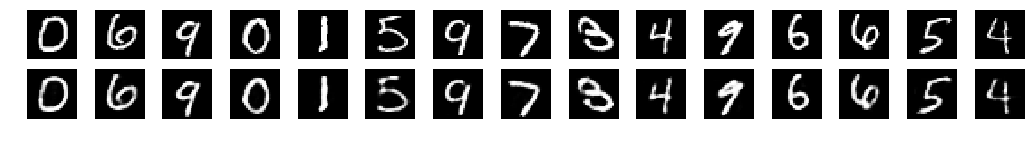

In [13]:
def display_reconstructed(original, reconstructed, n=10):
  plt.figure(figsize=[18,2])
  for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    if reconstructed is not None:
      plt.subplot(2, n, i + n + 1)
      plt.imshow(reconstructed[i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

x_test_batch = x_test[10:30]
reconstructed = model.reconstruction(x_test_batch)  
display_reconstructed(x_test_batch, reconstructed, 15)

La primera fila muestra las imágenes de entrada originales, la segunda fila muestra las reconstrucciones. Podemos ver que la reconstrucción es muy parecida a la imagen original, ello indica que con hemos conseguido aprender características que visualizaremos a continuación.

## Visualización del espacio latente de las características aprendidas

Podemos visualizar las representaciones de características del conjunto de datos MNIST después del entrenamiento, para ello entrenamos nuevamente el modelo pero reduciendo la dimensionalidad a 2D para la visualización del conjunto de datos de prueba.

In [14]:
model = Autoencoder(learning_rate=1e-3, epochs=50, feature_size=2)
model.train(train_dset, val_dset)

Starting epoch 1
Epoch (1/50): Train Loss (0.053) - Validation Loss (0.046)

Starting epoch 2
Epoch (2/50): Train Loss (0.043) - Validation Loss (0.042)

Starting epoch 3
Epoch (3/50): Train Loss (0.041) - Validation Loss (0.041)

Starting epoch 4
Epoch (4/50): Train Loss (0.039) - Validation Loss (0.040)

Starting epoch 5
Epoch (5/50): Train Loss (0.039) - Validation Loss (0.039)

Starting epoch 6
Epoch (6/50): Train Loss (0.038) - Validation Loss (0.039)

Starting epoch 7
Epoch (7/50): Train Loss (0.037) - Validation Loss (0.038)

Starting epoch 8
Epoch (8/50): Train Loss (0.037) - Validation Loss (0.038)

Starting epoch 9
Epoch (9/50): Train Loss (0.037) - Validation Loss (0.037)

Starting epoch 10
Epoch (10/50): Train Loss (0.036) - Validation Loss (0.037)

Starting epoch 11
Epoch (11/50): Train Loss (0.036) - Validation Loss (0.037)

Starting epoch 12
Epoch (12/50): Train Loss (0.036) - Validation Loss (0.037)

Starting epoch 13
Epoch (13/50): Train Loss (0.036) - Validation Loss 

Una vez tenemos el modelo entrenado, calculamos las representaciones de características del conjunto de datos de prueba (testset):

In [0]:
# obtener representaciones caracteriticas
test_features = model.latent_features_dataset(test_dset)

Visualizemos el espacio latente del conjunto de datos de prueba.

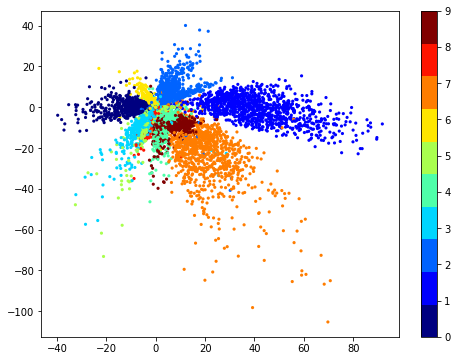

In [16]:
# plot con 2 dimensiones
fig = plt.figure(figsize=(8, 6))
plt.scatter(test_features[:, 0], test_features[:, 1], c=y_test, marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.colorbar()

## Visualización del espacio latente usando t-SNE

Podemos visualizar las representaciones de características del conjunto de datos MNIST después del entrenamiento, utilizamos t-SNE para la visualización del conjunto de datos de prueba. Para este fin, primero calculamos las representaciones de características del conjunto de datos de prueba:

In [17]:
model = Autoencoder(learning_rate=1e-3, epochs=10, feature_size=64)
model.train(train_dset, val_dset)

Starting epoch 1
Epoch (1/10): Train Loss (0.023) - Validation Loss (0.011)

Starting epoch 2
Epoch (2/10): Train Loss (0.009) - Validation Loss (0.008)

Starting epoch 3
Epoch (3/10): Train Loss (0.007) - Validation Loss (0.007)

Starting epoch 4
Epoch (4/10): Train Loss (0.006) - Validation Loss (0.006)

Starting epoch 5
Epoch (5/10): Train Loss (0.005) - Validation Loss (0.005)

Starting epoch 6
Epoch (6/10): Train Loss (0.005) - Validation Loss (0.005)

Starting epoch 7
Epoch (7/10): Train Loss (0.004) - Validation Loss (0.005)

Starting epoch 8
Epoch (8/10): Train Loss (0.004) - Validation Loss (0.005)

Starting epoch 9
Epoch (9/10): Train Loss (0.004) - Validation Loss (0.004)

Starting epoch 10
Epoch (10/10): Train Loss (0.004) - Validation Loss (0.004)



In [0]:
# obtener representaciones caracteriticas
test_features = model.latent_features_dataset(test_dset)

Usamos el módulo t-SNE de la biblioteca [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) para reducir la dimensionalidad de los datos a 2D para su visualización:

In [0]:
# importar TSNE de scikit-learn library
from sklearn.manifold import TSNE

# reducimos la dimensionalidad a 2D, consideramos un subconjunto de datos porque
# TSNE es un algoritmo pesado
tsne_features = TSNE(n_components=2).fit_transform(test_features[:5000,])

Visualizemos el espacio latente del conjunto de datos de prueba.

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


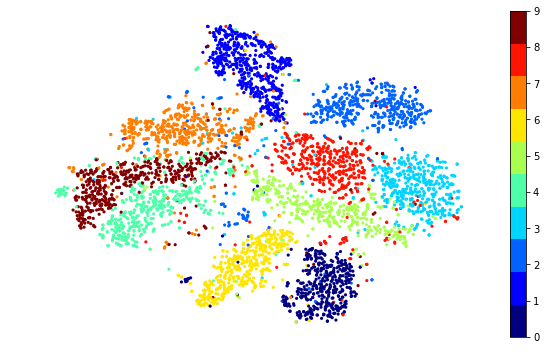

In [20]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y_test[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid('off')
plt.axis('off')
plt.colorbar()

## Clustering

Usaremos el algoritmo K-Means del módulo de clustering de la biblioteca [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html).

In [0]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Métricas de Evaluación

Usaremos dos métrics muy usadas en clustering: Clustering Accuracy (ACC) y Normalized Mutual Informacion (NMI).

In [0]:
class Metrics:

  def acc(self, Y_pred, Y):
    Y_pred, Y = np.array(Y_pred), np.array(Y)
    from sklearn.utils.linear_assignment_ import linear_assignment
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max())+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(Y_pred.size):
      w[Y_pred[i], Y[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i,j] for i,j in ind])*1.0/Y_pred.size
  
  def nmi(self, Y_pred, Y):
    Y_pred, Y = np.array(Y_pred), np.array(Y)
    assert Y_pred.size == Y.size
    from sklearn.metrics.cluster import normalized_mutual_info_score
    return normalized_mutual_info_score(Y_pred, Y, average_method='arithmetic')

### Baseline - PCA

Siempre es bueno definir un baseline con el cual comparar nuestros resultados. Nuestro baseline será usar PCA sobre MNIST para luego aplicar Clustering. Para ello primero realizamos un análisis de la data con PCA, para determinar el número de componentes a considerar.

#### Normalización de la data para el uso de PCA

In [0]:
# Normalizamos la data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_std = scaler.fit_transform(x_train)
val_std = scaler.transform(x_val)
test_std = scaler.transform(x_test)


#### Selección de Componentes

Text(0.5,1,"Single Variable's Explained Variance")

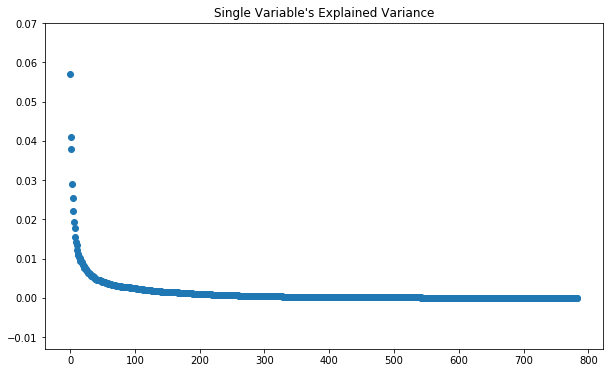

In [24]:
# Determinar la variance que aporta cada variable
from sklearn.decomposition import PCA

pca = PCA(n_components=28*28).fit(train_std)

plt.figure(figsize=(10,6))
plt.scatter(list(range(28*28)), pca.explained_variance_ratio_)
plt.title("Single Variable's Explained Variance")



Text(0.5,1,"Single Variable's Explained Variance")

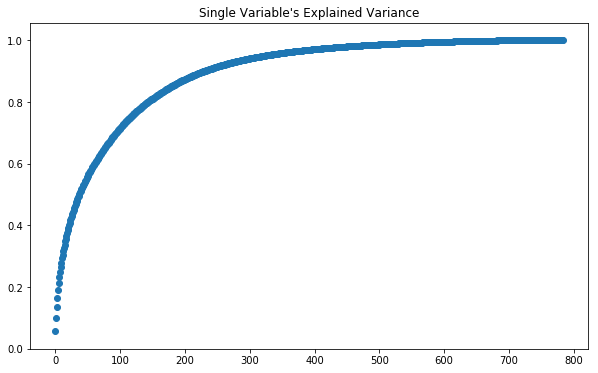

In [25]:
plt.figure(figsize=(10,6))
plt.scatter(list(range(28*28)), pca.explained_variance_ratio_.cumsum())
plt.title("Single Variable's Explained Variance")


In [26]:
pca.explained_variance_ratio_.cumsum()[250]

0.9145923

Otra forma de poder saber cuantas componentes son las mas adecuadas es aplicando directamente el porcentage de varianza a considerar:

In [0]:
pca = PCA(n_components=0.95).fit(train_std)

In [28]:
pca.n_components_

324

Como número final de componentes elegiremos $300$ el cual aplicamos a todos los datasets

In [0]:
num_components = 300
pca = PCA(n_components=num_components).fit(train_std)

In [30]:
pca_train_feat = pca.transform(train_std)
pca_val_feat = pca.transform(val_std)
pca_test_feat = pca.transform(test_std)

print("Train size: ", pca_train_feat.shape)
print("Val size: ", pca_val_feat.shape)
print("Test size: ", pca_test_feat.shape)

('Train size: ', (48000, 300))
('Val size: ', (12000, 300))
('Test size: ', (10000, 300))


#### Clustering con K-means

In [0]:
kmeans = KMeans(n_clusters=10, n_init=10, n_jobs=-1)
y_pca_kmeans_train = kmeans.fit_predict(pca_train_feat)

In [0]:
y_pca_kmeans_val = kmeans.predict(pca_val_feat)
y_pca_kmeans_test = kmeans.predict(pca_test_feat)

Evaluamos el baseline con las métricas ACC y NMI

In [33]:
def print_clustering_metrics(y_pred_kmeans, y_train, y_pred_kmeans_val, y_val, y_pred_kmeans_test, y_test):
  metrics = Metrics()
  base_train_acc = metrics.acc(y_pred_kmeans, y_train)
  base_train_nmi = metrics.nmi(y_pred_kmeans, y_train)
  base_val_acc = metrics.acc(y_pred_kmeans_val, y_val)
  base_val_nmi = metrics.nmi(y_pred_kmeans_val, y_val)
  base_test_acc = metrics.acc(y_pred_kmeans_test, y_test)
  base_test_nmi = metrics.nmi(y_pred_kmeans_test, y_test)
  print("Train ACC: %.3lf, NMI: %.3lf" % (base_train_acc, base_train_nmi))
  print("Val ACC: %.3lf, NMI: %.3lf" % (base_val_acc, base_val_nmi))
  print("Test ACC: %.3lf, NMI: %.3lf" % (base_test_acc, base_test_nmi))

print_clustering_metrics(y_pca_kmeans_train, y_train, y_pca_kmeans_val, y_val, y_pca_kmeans_test, y_test)

Train ACC: 0.490, NMI: 0.430
Val ACC: 0.487, NMI: 0.430
Test ACC: 0.490, NMI: 0.438


### Clustering usando Autoencoders

Usaremos nuestro modelo de autoencoders con el mismo número de componentes que PCA.

In [34]:
autoencoder = Autoencoder(learning_rate=1e-3, epochs=10, feature_size=num_components)
autoencoder.train(train_dset, val_dset)

Starting epoch 1
Epoch (1/10): Train Loss (0.021) - Validation Loss (0.010)

Starting epoch 2
Epoch (2/10): Train Loss (0.008) - Validation Loss (0.007)

Starting epoch 3
Epoch (3/10): Train Loss (0.006) - Validation Loss (0.005)

Starting epoch 4
Epoch (4/10): Train Loss (0.005) - Validation Loss (0.005)

Starting epoch 5
Epoch (5/10): Train Loss (0.004) - Validation Loss (0.004)

Starting epoch 6
Epoch (6/10): Train Loss (0.004) - Validation Loss (0.004)

Starting epoch 7
Epoch (7/10): Train Loss (0.004) - Validation Loss (0.004)

Starting epoch 8
Epoch (8/10): Train Loss (0.004) - Validation Loss (0.004)

Starting epoch 9
Epoch (9/10): Train Loss (0.003) - Validation Loss (0.004)

Starting epoch 10
Epoch (10/10): Train Loss (0.003) - Validation Loss (0.003)



Extraemos características luego de entrenar

In [35]:
ae_train_feat = autoencoder.latent_features_dataset(train_dset)
ae_val_feat = autoencoder.latent_features_dataset(val_dset)
ae_test_feat = autoencoder.latent_features_dataset(test_dset)

print("Train Features: ", ae_train_feat.shape)
print("Val Features: ", ae_val_feat.shape)
print("Test Features: ", ae_test_feat.shape)

('Train Features: ', (48000, 300))
('Val Features: ', (12000, 300))
('Test Features: ', (10000, 300))


#### Clusering con K-means

In [36]:
kmeans = KMeans(n_clusters=10, n_init=10, n_jobs=-1)
y_ae_kmeans_train = kmeans.fit_predict(ae_train_feat)
y_ae_kmeans_val = kmeans.predict(ae_val_feat)
y_ae_kmeans_test = kmeans.predict(ae_test_feat)

/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Evaluamos nuestro modelo de autoencoders con las métricas ACC y NMI

In [37]:
print_clustering_metrics(y_ae_kmeans_train, y_train, y_ae_kmeans_val, y_val, y_ae_kmeans_test, y_test)

Train ACC: 0.517, NMI: 0.495
Val ACC: 0.519, NMI: 0.493
Test ACC: 0.522, NMI: 0.498


## Denoising Autoencoder

![alt text](https://cdn-images-1.medium.com/max/800/1*SxwRp9i23OM0Up4sEze1QQ@2x.png)

In [0]:
class DenoisingAutoencoder():
  
  def __init__(self, **params):
    tf.reset_default_graph()
    ## Hiperparametros
    self.learning_rate = params.get("learning_rate", 1e-2)
    self.feature_size = params.get("feature_size", 64)
    self.num_epochs = params.get("epochs", 10)
    self.loss_type = params.get("loss_type", "mse")
    self.noise_factor = params.get("noise", 0.5)
    self.network = Networks()
    self.losses = LossFunction()
    self.sess = tf.Session()
  
  
  def evaluate(self, val_dset):
    ## Función para evaluar el modelo en un determinado dataset
    avg_loss = 0.
    # evaluamos el modelo para cada batch
    for x_batch, y_batch in val_dset:
      x_batch_noisy = x_batch + self.noise_factor * np.random.normal(0.0, 1.0, size=x_batch.shape) 
      _loss = self.sess.run(self.loss, feed_dict={self.x: x_batch, self.x_noisy: x_batch_noisy}) 
      avg_loss += _loss 
    # obtenemos el loss promedio de todo el dataset
    avg_loss /= val_dset.num_batches
    return avg_loss
  
  
  def train(self, train_dset, val_dset):
    # Construimos el grafo computacional que usaremos para entrenar el modelo.
    self.output_size = 28*28
    self.x = tf.placeholder(tf.float32, [None, self.output_size])
    self.x_noisy = tf.placeholder(tf.float32, [None, self.output_size])
    
    # Usamos nuestro modelo encoder-decoder para obtener las reconstrucciones
    x_hat = self.network.encoder_decoder(self.x_noisy, self.feature_size, self.output_size)

    # Calculamos la función de pérdida;
    if self.loss_type == "mse":
      self.loss = self.losses.mean_squared_error(self.x, x_hat)
    else:
      self.loss = self.losses.binary_cross_entropy(self.x, x_hat)
    
    # Usamos la función que proporciona un Optimizer, luego usamos el
    # optimizador para definir los pasos de entrenamiento. Haciendo una llamada
    # a este método, realizará el proceso de optimización para el batch actual
    optimizer = tf.train.AdamOptimizer(self.learning_rate)
    train_op = optimizer.minimize(self.loss)
    
    # Inicializamos las variables globales
    self.sess.run(tf.global_variables_initializer())
    
    # iteramos dado el número de épocas
    for epoch in range(self.num_epochs):
      print('Starting epoch %d' % (epoch + 1) )  
      avg_train_loss = 0.
            
      # entrenamos el modelo para cada batch
      for x_batch, y_batch in train_dset:
        x_batch_noisy = x_batch + self.noise_factor * np.random.normal(0.0, 1.0, size=x_batch.shape) 
        # especificamos los valores de entrada para los placeholders
        feed_dict = {self.x: x_batch, self.x_noisy: x_batch_noisy}
        # Ejecutamos el grafo con el batch actual, realizamos el paso
        # forward y backward (optimización)
        _loss, _ = self.sess.run([self.loss, train_op], feed_dict=feed_dict)       
        avg_train_loss += _loss
      
      # obtenemos el loss promedio de toda la data de entrenamiento
      avg_train_loss /= train_dset.num_batches
      
      # fase de validación
      avg_val_loss = self.evaluate(val_dset)
      
      # Periodicamente imprimimos la pérdida  
      print('Epoch (%d/%d): Train Loss (%.3f) - Validation Loss (%.3f)\n' % (epoch + 1, self.num_epochs, avg_train_loss, avg_val_loss))
    
    
  def reconstruction(self, data):
    ## Reconstrucción dado un conjunto de datos
    # Usamos nuestro modelo encoder-decoder para obtener las reconstrucciones
    data_noisy = data + self.noise_factor * np.random.normal(0.0, 1.0, size=data.shape) 
    x_hat = self.network.encoder_decoder(self.x, self.feature_size, self.output_size)
    reconstruction = self.sess.run(x_hat, feed_dict={self.x:data, self.x_noisy:data_noisy})
    return reconstruction, data_noisy
  
  
  def latent_features_dataset(self, dataset):
    ## Obtener caracteristicas aprendidas por el modelo
    z = self.network.encoder(self.x, self.feature_size)
    features = np.zeros((dataset.num_elements, self.feature_size))
    it = 0
    for x_batch, y_batch in dataset:
      n = x_batch.shape[0]
      features[it*n:it*n+n] = self.sess.run(z, feed_dict={self.x:x_batch})
      it = it + 1
    return features


### Entrenamiento

In [39]:
denoising = DenoisingAutoencoder(learning_rate=1e-3, epochs=10, feature_size=64)
denoising.train(train_dset, val_dset)

Starting epoch 1
Epoch (1/10): Train Loss (0.033) - Validation Loss (0.022)

Starting epoch 2
Epoch (2/10): Train Loss (0.019) - Validation Loss (0.018)

Starting epoch 3
Epoch (3/10): Train Loss (0.017) - Validation Loss (0.017)

Starting epoch 4
Epoch (4/10): Train Loss (0.016) - Validation Loss (0.016)

Starting epoch 5
Epoch (5/10): Train Loss (0.015) - Validation Loss (0.016)

Starting epoch 6
Epoch (6/10): Train Loss (0.015) - Validation Loss (0.015)

Starting epoch 7
Epoch (7/10): Train Loss (0.015) - Validation Loss (0.015)

Starting epoch 8
Epoch (8/10): Train Loss (0.014) - Validation Loss (0.014)

Starting epoch 9
Epoch (9/10): Train Loss (0.014) - Validation Loss (0.014)

Starting epoch 10
Epoch (10/10): Train Loss (0.014) - Validation Loss (0.014)



## Reconstrucción de Imágenes

A continuación visualizaremos las reconstrucciones aprendidas por nuestro modelo

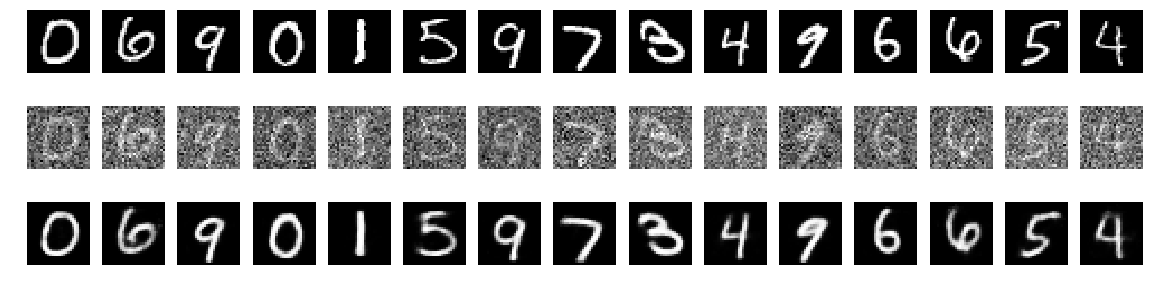

In [40]:
def display_reconstructed_noisy(original, reconstructed, noisy, n=10):
  plt.figure(figsize=[20,5])
  for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(original[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    if noisy is not None:
      plt.subplot(3, n, i + n + 1)
      plt.imshow(noisy[i].reshape(28, 28))
      plt.gray()
      plt.axis('off')      
    
    if reconstructed is not None:
      plt.subplot(3, n, i + 2 * n + 1 )
      plt.imshow(reconstructed[i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()
  
x_test_batch = x_test[10:30]
reconstructed, data_noisy = denoising.reconstruction(x_test_batch)  
display_reconstructed_noisy(x_test_batch, reconstructed, data_noisy, 15)

## Clustering

In [41]:
denoising = DenoisingAutoencoder(learning_rate=1e-3, epochs=20, feature_size=num_components)
denoising.train(train_dset, val_dset)

Starting epoch 1
Epoch (1/20): Train Loss (0.032) - Validation Loss (0.021)

Starting epoch 2
Epoch (2/20): Train Loss (0.019) - Validation Loss (0.018)

Starting epoch 3
Epoch (3/20): Train Loss (0.017) - Validation Loss (0.017)

Starting epoch 4
Epoch (4/20): Train Loss (0.016) - Validation Loss (0.016)

Starting epoch 5
Epoch (5/20): Train Loss (0.015) - Validation Loss (0.016)

Starting epoch 6
Epoch (6/20): Train Loss (0.015) - Validation Loss (0.015)

Starting epoch 7
Epoch (7/20): Train Loss (0.015) - Validation Loss (0.015)

Starting epoch 8
Epoch (8/20): Train Loss (0.014) - Validation Loss (0.015)

Starting epoch 9
Epoch (9/20): Train Loss (0.014) - Validation Loss (0.015)

Starting epoch 10
Epoch (10/20): Train Loss (0.014) - Validation Loss (0.014)

Starting epoch 11
Epoch (11/20): Train Loss (0.014) - Validation Loss (0.014)

Starting epoch 12
Epoch (12/20): Train Loss (0.014) - Validation Loss (0.014)

Starting epoch 13
Epoch (13/20): Train Loss (0.013) - Validation Loss 

Extraemos caracteristicas de nuestro denoising autoencoder.

In [42]:
deno_train_feat = denoising.latent_features_dataset(train_dset)
deno_val_feat = denoising.latent_features_dataset(val_dset)
deno_test_feat = denoising.latent_features_dataset(test_dset)

print("Train Features: ", deno_train_feat.shape)
print("Val Features: ", deno_val_feat.shape)
print("Test Features: ", deno_test_feat.shape)

('Train Features: ', (48000, 300))
('Val Features: ', (12000, 300))
('Test Features: ', (10000, 300))


Entrenamos K-means y predecimos los clusters

In [0]:
kmeans = KMeans(n_clusters=10, n_init=10, n_jobs=-1)
y_deno_kmeans_train = kmeans.fit_predict(deno_train_feat)
y_deno_kmeans_val = kmeans.predict(deno_val_feat)
y_deno_kmeans_test = kmeans.predict(deno_test_feat)

Evaluamos nuestro modelo de autoencoders con las métricas ACC y NMI

In [44]:
print_clustering_metrics(y_deno_kmeans_train, y_train, y_deno_kmeans_val, y_val, y_deno_kmeans_test, y_test)

Train ACC: 0.609, NMI: 0.605
Val ACC: 0.607, NMI: 0.601
Test ACC: 0.609, NMI: 0.610


## Clasificación

Compararemos las características de nuestro baseline con nuestros dos autoencoders en el problema de clasificación mediante K-Nearest Neighbor.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#knn = LogisticRegression(n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', n_jobs=-1)

Reducimos el número de características para poder ejecutar algoritmos de clasificación.

In [46]:
##PCA
num_components = 64
pca = PCA(n_components=num_components).fit(train_std)

pca_train_feat = pca.transform(train_std)
pca_val_feat = pca.transform(val_std)
pca_test_feat = pca.transform(test_std)

print("PCA Train size: ", pca_train_feat.shape)
print("PCA Val size: ", pca_val_feat.shape)
print("PCA Test size: ", pca_test_feat.shape)

('PCA Train size: ', (48000, 64))
('PCA Val size: ', (12000, 64))
('PCA Test size: ', (10000, 64))


In [47]:
##Autoencoder
autoencoder = Autoencoder(learning_rate=1e-3, epochs=10, feature_size=num_components)
autoencoder.train(train_dset, val_dset)

ae_train_feat = autoencoder.latent_features_dataset(train_dset)
ae_val_feat = autoencoder.latent_features_dataset(val_dset)
ae_test_feat = autoencoder.latent_features_dataset(test_dset)

print("AE Train Features: ", ae_train_feat.shape)
print("AE Val Features: ", ae_val_feat.shape)
print("AE Test Features: ", ae_test_feat.shape)

Starting epoch 1
Epoch (1/10): Train Loss (0.023) - Validation Loss (0.011)

Starting epoch 2
Epoch (2/10): Train Loss (0.009) - Validation Loss (0.008)

Starting epoch 3
Epoch (3/10): Train Loss (0.007) - Validation Loss (0.007)

Starting epoch 4
Epoch (4/10): Train Loss (0.006) - Validation Loss (0.006)

Starting epoch 5
Epoch (5/10): Train Loss (0.005) - Validation Loss (0.005)

Starting epoch 6
Epoch (6/10): Train Loss (0.005) - Validation Loss (0.005)

Starting epoch 7
Epoch (7/10): Train Loss (0.004) - Validation Loss (0.005)

Starting epoch 8
Epoch (8/10): Train Loss (0.004) - Validation Loss (0.005)

Starting epoch 9
Epoch (9/10): Train Loss (0.004) - Validation Loss (0.004)

Starting epoch 10
Epoch (10/10): Train Loss (0.004) - Validation Loss (0.004)

('AE Train Features: ', (48000, 64))
('AE Val Features: ', (12000, 64))
('AE Test Features: ', (10000, 64))


In [48]:
##Denoising
denoising = DenoisingAutoencoder(learning_rate=1e-3, epochs=20, feature_size=num_components)
denoising.train(train_dset, val_dset)

deno_train_feat = denoising.latent_features_dataset(train_dset)
deno_val_feat = denoising.latent_features_dataset(val_dset)
deno_test_feat = denoising.latent_features_dataset(test_dset)

print("Denoising Train Features: ", deno_train_feat.shape)
print("Denoising Val Features: ", deno_val_feat.shape)
print("DenoisingTest Features: ", deno_test_feat.shape)

Starting epoch 1
Epoch (1/20): Train Loss (0.032) - Validation Loss (0.021)

Starting epoch 2
Epoch (2/20): Train Loss (0.019) - Validation Loss (0.019)

Starting epoch 3
Epoch (3/20): Train Loss (0.017) - Validation Loss (0.017)

Starting epoch 4
Epoch (4/20): Train Loss (0.016) - Validation Loss (0.016)

Starting epoch 5
Epoch (5/20): Train Loss (0.015) - Validation Loss (0.016)

Starting epoch 6
Epoch (6/20): Train Loss (0.015) - Validation Loss (0.015)

Starting epoch 7
Epoch (7/20): Train Loss (0.015) - Validation Loss (0.015)

Starting epoch 8
Epoch (8/20): Train Loss (0.014) - Validation Loss (0.014)

Starting epoch 9
Epoch (9/20): Train Loss (0.014) - Validation Loss (0.014)

Starting epoch 10
Epoch (10/20): Train Loss (0.014) - Validation Loss (0.014)

Starting epoch 11
Epoch (11/20): Train Loss (0.014) - Validation Loss (0.014)

Starting epoch 12
Epoch (12/20): Train Loss (0.013) - Validation Loss (0.014)

Starting epoch 13
Epoch (13/20): Train Loss (0.013) - Validation Loss 

### Baseline - PCA

In [0]:
knn.fit(pca_train_feat, y_train) 

y_knn_pca_val = knn.predict(pca_val_feat)
y_knn_pca_test = knn.predict(pca_test_feat)

Evaluamos nuestro modelo con accuracy.

In [50]:
from sklearn.metrics import accuracy_score
pca_val_acc = accuracy_score(y_knn_pca_val, y_val)
pca_test_acc = accuracy_score(y_knn_pca_test, y_test)
print("KNN-PCA - Val Accuracy: %.3lf; Test Accuracy: %.3lf" % (pca_val_acc, pca_test_acc) )

KNN-PCA - Val Accuracy: 0.960; Test Accuracy: 0.956


### Vanilla Autoencoder

In [0]:
knn.fit(ae_train_feat, y_train) 
y_knn_ae_val = knn.predict(ae_val_feat)
y_knn_ae_test = knn.predict(ae_test_feat)

In [52]:
from sklearn.metrics import accuracy_score
ae_val_acc = accuracy_score(y_knn_ae_val, y_val)
ae_test_acc = accuracy_score(y_knn_ae_test, y_test)
print("KNN-AE - Val Accuracy: %.3lf; Test Accuracy: %.3lf" % (ae_val_acc, ae_test_acc) )

KNN-AE - Val Accuracy: 0.971; Test Accuracy: 0.966


### Denoising Autoencoder

In [0]:
knn.fit(deno_train_feat, y_train) 
y_knn_deno_val = knn.predict(deno_val_feat)
y_knn_deno_test = knn.predict(deno_test_feat)

In [54]:
from sklearn.metrics import accuracy_score
deno_val_acc = accuracy_score(y_knn_deno_val, y_val)
deno_test_acc = accuracy_score(y_knn_deno_test, y_test)
print("KNN-DenAE - Val Accuracy: %.3lf; Test Accuracy: %.3lf" % (deno_val_acc, deno_test_acc) )

KNN-DenAE - Val Accuracy: 0.974; Test Accuracy: 0.969
